# Assignment 2
### \<Xingyi Qiu> \<a1895774>

## A. Tasks as specified for your team structure

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/NLP_2')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import BertForQuestionAnswering, BertTokenizer
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaForQuestionAnswering, AdamW
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizerFast
import json
from collections import Counter
import string
from transformers import AutoTokenizer,AdamW,BertForQuestionAnswering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!python -m spacy download en_core_web_md


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 15.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# 1.Data Preparation

Use Python and the pandas library to process a news article dataset (news_dataset.csv), as well as the data preparation phase of using this data to create a question and answer system.

## 1.1.Load dataset

In [ ]:
# Function to get article by ID
def get_article_by_id(article_id):
    article = news_df[news_df['id'] == article_id]['article'].values
    return article[0] if len(article) > 0 else ""

# Function to preprocess text
def preprocess_text(text):
    text = text.strip().replace("  ", "").lower()
    return text



In [ ]:
# Load the original news dataset
news_df = pd.read_csv('news_dataset.csv', encoding='ISO-8859-1')
news_df['article'] = news_df['article'].apply(preprocess_text)
news_df.head()

,id,author,date,year,month,topic,article
0,17307,Marlise Simons,1/01/2017,2017,1,architecture,paris? when the islamic state was about to be ...
1,17292,Andy Newman,31/12/2016,2016,12,art,angels are everywhere in the mu?iz family?s ap...
2,17298,Emma G. Fitzsimmons,2/01/2017,2017,1,business,finally. the second avenue subway opened in ne...
3,17311,Carl Hulse,3/01/2017,2017,1,business,washington? it?s or time for republicans. afte...
4,17339,Jim Rutenberg,5/01/2017,2017,1,business,"for megyn kelly, the shift from fox news to nb..."


In [ ]:
# Load Read our own defined QA data (define QA based on news data)
qa_df = pd.read_excel('QA-60.xlsx')
qa_df = qa_df[qa_df['answer'].notnull()]
qa_df['article'] = qa_df['article'].apply(preprocess_text)
qa_df['answer'] = qa_df['answer'].apply(preprocess_text)
qa_df['question'] = qa_df['question'].apply(preprocess_text)
qa_df['id'] = qa_df['id'].astype(int)

# Calculate start and end positions
qa_df['start_position'] = qa_df.apply(lambda row: row['article'].find(row['answer']), axis=1)
qa_df['end_position'] = qa_df.apply(lambda row: row['start_position'] + len(row['answer']), axis=1)
qa_df = qa_df[qa_df['start_position'] > -1]
qa_df.head()

,id,author,date,year,month,topic,article,question,answer,start_position,end_position
0,17283,Carl Hulse,31/12/2016,2016,12,politics,washington? congressional republicans have a n...,who ruled that house republicans had the stand...,judge collyer,2242,2255
1,17284,Benjamin Mueller and Al Baker,19/06/2017,2017,6,crime,"after the bullet shells get counted, the blood...",what is the highest murder rate in new york ci...,the 40th precinct,489,506
3,17286,William McDonald,10/04/2017,2017,4,entertainment,"death may be the great equalizer, but it isn?t...",which pop artist was mentioned as having passe...,david bowie,317,328
4,17287,Choe Sang-Hun,2/01/2017,2017,1,politics,"seoul, south korea? north korea?s leader, kim ...",what type of missile is north korea preparing ...,intercontinental ballistic missile,140,174
5,17289,Javier C. Hern姣弉dez,2/01/2017,2017,1,politics,beijing? president tsai of taiwan sharply crit...,what types of threats did president tsai criti...,military and economic threats,110,139


In [ ]:
# Load the SQuAD version 2.0
def load_SQuAD_QA(fileName):
    with open(fileName , 'r') as file:
        data = json.load(file)
    data = data['data'][0]['paragraphs']
    QA_datas = []
    for d in data:
        qas = d['qas']
        context = d['context']
        for qa in qas:
            question = qa['question']
            answers = qa['answers']
            for answer in answers:
                answer_text = answer['text']
                QA_datas.append([context, question, answer_text])

    SQuAD_df = pd.DataFrame(QA_datas, columns = ['article', 'question', 'answer'])
    SQuAD_df = SQuAD_df.drop_duplicates()
    return SQuAD_df

fileName = './SQuAD/dev-v2.0.json'
SQuAD_df = load_SQuAD_QA(fileName)
SQuAD_df = SQuAD_df.reset_index(drop = True)
SQuAD_df['article'] = SQuAD_df['article'].apply(preprocess_text)
SQuAD_df['answer'] = SQuAD_df['answer'].apply(preprocess_text)

# Calculate start and end positions
SQuAD_df['start_position'] = SQuAD_df.apply(lambda row: row['article'].find(row['answer']), axis=1)
SQuAD_df['end_position'] = SQuAD_df.apply(lambda row: row['start_position'] + len(row['answer']), axis=1)

SQuAD_df.head()


,article,question,answer,start_position,end_position
0,the normans (norman: nourmands; french: norman...,In what country is Normandy located?,france,159,165
1,the normans (norman: nourmands; french: norman...,When were the Normans in Normandy?,10th and 11th centuries,94,117
2,the normans (norman: nourmands; french: norman...,When were the Normans in Normandy?,in the 10th and 11th centuries,87,117
3,the normans (norman: nourmands; french: norman...,From which countries did the Norse originate?,"denmark, iceland and norway",256,283
4,the normans (norman: nourmands; french: norman...,Who was the Norse leader?,rollo,308,313


## 1.2.Set data

In [ ]:
# train data
train_articles = qa_df['article'].tolist()
train_questions = qa_df['question'].tolist()
train_answers = []
for answer, start_position, end_position in zip(qa_df['answer'], qa_df['start_position'], qa_df['end_position']):
  answer_dict = {'text': answer, 'answer_start': start_position, 'answer_end': end_position}
  train_answers.append(answer_dict)

# test data (SQuAD)
test_articles = SQuAD_df['article'].tolist()
test_questions = SQuAD_df['question'].tolist()
test_answers = []
for answer, start_position, end_position in zip(SQuAD_df['answer'], SQuAD_df['start_position'], SQuAD_df['end_position']):
  answer_dict = {'text': answer, 'answer_start': start_position, 'answer_end': end_position}
  test_answers.append(answer_dict)

In [ ]:
# check the data
print(len(train_articles), len(train_questions), len(train_answers))
print(len(test_articles), len(test_questions), len(test_answers))


41 41 41
136 136 136


In [ ]:
print("Article: ",train_articles[0])
print("Question: ",train_questions[0])
print("Answer: ",train_answers[0])

Article:  washington? congressional republicans have a new fear when it comes to theirhealth care lawsuit against the obama administration: they might win. the incoming trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration?s authority to spend billions of dollars on health insurance subsidies for and americans, handing house republicans a big victory onissues. but a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before republicans have prepared a replacement. that could lead to chaos in the insurance market and spur a political backlash just as republicans gain full control of the government. to stave off that outcome, republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the obama health care law, angering conservative voters who have been demandi

# 2.Coreference Resolution utility
This will Help to identify which entity a phrase in the sentence is referring to.

In [ ]:
nlp = spacy.load('en_core_web_sm')

# Dictionary to store coreference results
coref_results = {}
# Process each article
for index, row in news_df.iterrows():
    # Process the article text with nlp
    doc = nlp(row['article'])
    entities = list(doc.ents)
    noun_phrases = list(doc.noun_chunks)
    corefs = []
    for token in doc:
      if token.pos_ == 'PRON':
        for noun_phrase in reversed(noun_phrases):
          if noun_phrase.end <= token.i:
            corefs.append(f"{token} refer to {noun_phrase}")
            break

    coref_results[row['id']] = corefs

coref_results[17574]

['that refer to the corruption scandal',
 'him refer to wednesday',
 'which refer to the special prosecutor?s office',
 'he refer to which',
 'he refer to samsung, south korea?s largest conglomerate',
 'its refer to the son',
 'who refer to lee',
 'he refer to health problems',
 'that refer to donations',
 'any refer to what role',
 'he refer to what role',
 'that refer to the corruption scandal',
 'her refer to the national assembly?s vote',
 'she refer to ms. park?s powers',
 'which refer to the constitutional court',
 'her refer to which',
 'he refer to a national assembly hearing',
 'he refer to the donations',
 'it refer to the special prosecutor?s office',
 'it refer to the president',
 'which refer to mr. lee',
 'her refer to samsung',
 'they refer to her two foundations',
 'all refer to the businesses',
 'which refer to all',
 'they refer to which',
 'its refer to government pressure',
 'which refer to the special prosecutor',
 'it refer to the other corporate contributors',
 '

# 3.Text matching utility
Find most relevant sentence, part of sentence or phrase and its confidence score in the article based on the user question.

In [ ]:
nlp = spacy.load('en_core_web_md')

def find_most_relevant_sentence(article, question):
    question_doc = nlp(question)
    article_doc = nlp(article)
    max_score = 0
    most_relevant_sentence = None
    for sent in article_doc.sents:
        score = sent.similarity(question_doc)
        if score > max_score:
            max_score = score
            most_relevant_sentence = sent.text

    return most_relevant_sentence, max_score


def find_relevant_sentences(article, question, threshod = 0.8):
    question_doc = nlp(question)
    article_doc = nlp(article)
    sentences_list = []
    for sent in article_doc.sents:
      score = sent.similarity(question_doc)
      if score > threshod:
        sentences_list.append(sent.text)
    most_relevant_sentence = " ".join(sentences_list)
    return most_relevant_sentence

def find_n_relevant_sentences(article, question, n = 3):
    question_doc = nlp(question)
    article_doc = nlp(article)
    sentences_list = []
    score_list = []
    for sent in article_doc.sents:
      score = sent.similarity(question_doc)
      sentences_list.append(sent.text)
      score_list.append(score)
    inds = np.argsort(score_list)[::-1][:n]
    best_n_sentences = np.array(sentences_list)[inds]
    best_n_sentences = best_n_sentences.tolist()
    most_relevant_sentence = ' '.join(best_n_sentences)
    return most_relevant_sentence

In [ ]:
# sample test
article = get_article_by_id(17574)
question = 'Who is the vice chairman of Samsung'
print("Article:", article)
print()
print("Question:", question)
most_relevant_sentence, max_score = find_most_relevant_sentence(article, question)
print("The most relevant sentence:")
print(most_relevant_sentence)



Article: seoul, south korea? a special prosecutor investigating the corruption scandal that led to president park?s impeachment summoned the de facto head of samsung for questioning on wednesday, calling him a bribery suspect. the de facto leader, jay y. lee, the vice chairman of samsung, will be questioned on thursday, according to the special prosecutor?s office, which recommended that he also be investigated on suspicion of perjury. mr. lee effectively runs samsung, south korea?s largest conglomerate he is the son of its chairman, lee who has been incapacitated with health problems. he is expected to be asked whether donations that samsung made to two foundations controlled by choi a longtime friend of the president, amounted to bribes, and what role, if any, he played in the decision to give the money. investigators at the special prosecutor?s office have questioned other senior samsung executives as suspects about the bribery accusations. neither samsung nor mr. lee responded imme

# 4.Test utility
Develop a test utility that accepts an article, a set of test questions with answers andoutputs a metric.




# Train a model for QA system:


## 4.1.Load pretrained model -- BERT


In [ ]:
# Load tokenizer and model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

bert_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
bert_model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
bert_model.to(device)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


# Tokenize articles and questions
train_encodings = tokenizer(train_articles, train_questions, truncation=True, padding=True)
test_encodings = tokenizer(test_articles, test_questions, truncation=True, padding=True)

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 4.2.Convert the start-end positions to tokens start-end positions

In [ ]:
# Convert the start-end positions to tokens start-end positions
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []

    count = 0

    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(
            i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(
            i, answers[i]['answer_end']))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length

        # if end position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
        if end_positions[-1] is None:
            end_positions[-1] = encodings.char_to_token(
                i, answers[i]['answer_end'] - 1)
            # if end position is still None the answer passage has been truncated
            if end_positions[-1] is None:
                count += 1
                end_positions[-1] = tokenizer.model_max_length

    # Update the data in dictionary
    encodings.update({'start_positions': start_positions,
                     'end_positions': end_positions})


add_token_positions(train_encodings, train_answers)
add_token_positions(test_encodings, test_answers)

## 4.3.DataLoader

In [ ]:
# Create a Squatdataset class (inherits from torch.utils.data.Dataset),
class QAdataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = QAdataset(train_encodings)
test_dataset = QAdataset(test_encodings)

# Use of DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Build the Bert model
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad').to(device)
optim = AdamW(model.parameters(), lr=1e-5)


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##  4.4.Model fine-tuning


In [ ]:
# Train and Evaluate Model
epochs = 20
train_losses = []
test_losses = []

print_every = 1000

for epoch in range(epochs):
  # Set model in train mode
  model.train()
  loss_of_epoch = 0

  for batch_idx,batch in enumerate(train_loader):

    optim.zero_grad()

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    # do a backwards pass
    loss.backward()
    # update the weights
    optim.step()
    # Find the total loss
    loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
      print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(train_loader)
  train_losses.append(loss_of_epoch)

  # Print each epoch's loss
  print("Epoch {}, Training Loss: {:.4f}".format(epoch, loss_of_epoch))



Epoch 0, Training Loss: 4.1394
Epoch 1, Training Loss: 2.0659
Epoch 2, Training Loss: 1.3178
Epoch 3, Training Loss: 0.8856
Epoch 4, Training Loss: 0.7667
Epoch 5, Training Loss: 0.3180
Epoch 6, Training Loss: 0.1892
Epoch 7, Training Loss: 0.1282
Epoch 8, Training Loss: 0.0835
Epoch 9, Training Loss: 0.0681
Epoch 10, Training Loss: 0.0353
Epoch 11, Training Loss: 0.0245
Epoch 12, Training Loss: 0.0170
Epoch 13, Training Loss: 0.0146
Epoch 14, Training Loss: 0.0114
Epoch 15, Training Loss: 0.0088
Epoch 16, Training Loss: 0.0089
Epoch 17, Training Loss: 0.0123
Epoch 18, Training Loss: 0.0151
Epoch 19, Training Loss: 0.0054


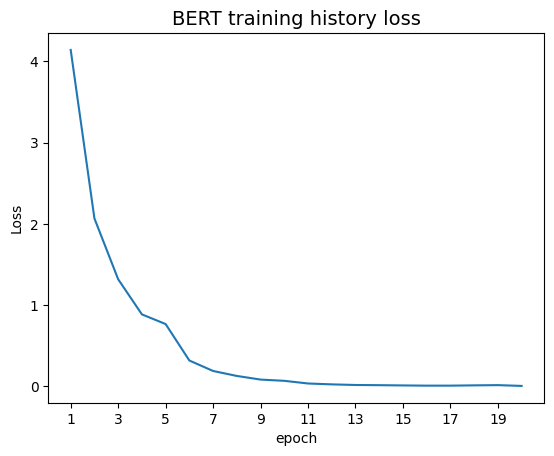

In [ ]:
plt.plot(range(1, epochs+1), train_losses)
plt.xticks(range(1, epochs+1,2))
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("BERT training history loss", size = 14)
plt.show()

## 4.5.Model performance evaluation:'F1', 'EM'

Test application with at least 10 test questions and show the results using your chosen metric.


In [ ]:
def generate_answer(question, context, tokenizer, model ):
    model.eval()  # Set the model to evaluation mode
    # Truncation processing: First truncate the context to ensure that the total length does not exceed the model limit
    encoded_input = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt", truncation=True, max_length=512)
    input_ids = encoded_input["input_ids"].to(device)
    attention_mask = encoded_input["attention_mask"].to(device)

    # Do not calculate gradients
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    # Get the start and end positions of the most likely answer from the output
    answer_start_scores, answer_end_scores = outputs.start_logits, outputs.end_logits
    answer_start = torch.argmax(answer_start_scores)
    answer_end = torch.argmax(answer_end_scores) + 1

    # If answer_start or answer_end is out of range, reset to the minimum or maximum value of the input length
    if answer_end > input_ids.shape[1]:
        answer_end = input_ids.shape[1]
    if answer_start >= answer_end:  # If the start position is not logical, reset the start position
        answer_start = max(answer_end - 1, 0)

    # Convert token ids back to text
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[0][answer_start:answer_end]))

    if len(answer) == 0:
      return "There is no answer"
    return answer


In [ ]:
# test QA with article
article = get_article_by_id(17283)
question = 'who ruled that house republicans had the standing to sue the executive branch?'
print("Article:")
print(article)
print()
print("Question:", question)

answer = generate_answer(question, article, tokenizer = tokenizer, model = model)
print("Answer model:")
print(answer)


Article:
washington? congressional republicans have a new fear when it comes to theirhealth care lawsuit against the obama administration: they might win. the incoming trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration?s authority to spend billions of dollars on health insurance subsidies for and americans, handing house republicans a big victory onissues. but a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before republicans have prepared a replacement. that could lead to chaos in the insurance market and spur a political backlash just as republicans gain full control of the government. to stave off that outcome, republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the obama health care law, angering conservative voters who have been demandin

In [ ]:
stop_words = set(stopwords.words('english'))

def normalize_answer(text):
    text = text.replace("  ", ' ')
    # 去除特殊字符
    text = re.sub(r'\W', ' ', str(text))
    # 去除单个字符
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # 替换多个空格为一个空格
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # 去除停用词
    text = ' '.join([word for word in text.lower().split() if word not in stop_words])
    return text


def calculate_f1(predicted_answer, actual_answer):
    predicted_answer = normalize_answer(predicted_answer)
    actual_answer = normalize_answer(actual_answer)

    predicted_tokens = predicted_answer.split()
    actual_tokens = actual_answer.split()
    common = Counter(predicted_tokens) & Counter(actual_tokens)
    num_same = sum(common.values())
    if len(actual_tokens) == 0 or len(predicted_tokens) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(predicted_tokens == actual_tokens)
    if num_same == 0:
        return 0

    precision = 1.0 * num_same / len(predicted_tokens)
    recall = 1.0 * num_same / len(actual_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def calculate_mrr(predicted_answers, true_answer):
    if not true_answer:
        return 0
    for index, answer in enumerate(predicted_answers):
        if answer == true_answer:
            return 1.0 / (index + 1)

    return 0

def compute_exact_match(predicted_answer, actual_answer):
    return int(predicted_answer == actual_answer)

In [ ]:
# Training set evaluation
train_result_datas = []
for id, article, question, answer in zip(qa_df['id'], qa_df['article'], qa_df['question'], qa_df['answer']):
  pred_answer = generate_answer(question, article, tokenizer = tokenizer, model = model)
  normalized_pred_answer = normalize_answer(pred_answer)
  normalized_answer = normalize_answer(answer)
  f1 = calculate_f1(normalized_pred_answer, normalized_answer)
  EM = compute_exact_match(normalized_pred_answer, normalized_answer)
  train_result_datas.append([id, question, normalized_pred_answer,f1, EM])

train_result_df = pd.DataFrame(train_result_datas, columns = ['article ID', 'question', 'model answer', 'F1', 'EM'])
train_result_df = train_result_df.sort_values("F1")[::-1].reset_index(drop = True)

train_mean_F1 = train_result_df['F1'].mean()
train_mean_EM = train_result_df['EM'].mean()

print("Average F1-score of the training set:", round(train_mean_F1,4))
print("Average EM of the training set:", round(train_mean_EM,4))

train_result_df

Average F1-score of the training set: 0.8748
Average EM of the training set: 0.8293


,article ID,question,model answer,F1,EM
0,17360,which country topped the new york times’ list ...,canada,1.000000,1
1,17298,what subway line opened in new york as mention...,second avenue subway,1.000000,1
2,17309,what law are republicans planning to repeal qu...,affordable care act,1.000000,1
3,17308,who directed the music video for george michae...,david fincher,1.000000,1
4,17307,what was used to cause damage in palmyra when ...,explosives,1.000000,1
5,17306,where did mariah carey's performance take plac...,times square,1.000000,1
6,17303,what is causing the pollution at melbourne's b...,fecal pollution,1.000000,1
7,17302,what group claimed responsibility for the suic...,islamic state,1.000000,1
8,17301,who is the prime minister of india mentioned i...,narendra modi,1.000000,1
9,17297,what type of prints did the article discuss fo...,engineer prints,1.000000,1


In [ ]:
# Testing set evaluation
test_result_datas = []
for article, question, answer in zip(SQuAD_df['article'], SQuAD_df['question'], SQuAD_df['answer']):
  pred_answer = generate_answer(question, article, tokenizer, model)
  normalized_pred_answer = normalize_answer(pred_answer)
  normalized_answer = normalize_answer(answer)
  f1 = calculate_f1(normalized_pred_answer, normalized_answer)
  EM = compute_exact_match(normalized_pred_answer, normalized_answer)
  test_result_datas.append([question, normalized_pred_answer,f1, EM])

test_result_df = pd.DataFrame(test_result_datas, columns = ['question', 'model answer', 'F1', 'EM'])
test_result_df = test_result_df.sort_values("F1")[::-1].reset_index(drop = True)

test_mean_F1 = test_result_df['F1'].mean()
test_mean_EM = test_result_df['EM'].mean()

print("Average F1-score of the testing set:", round(test_mean_F1,4))
print("Average EM of the testing set:", round(test_mean_EM,4))

test_result_df

Average F1-score of the testing set: 0.8264
Average EM of the testing set: 0.6838


,question,model answer,F1,EM
0,What tradition were the Saint-Evroul monks kno...,singing,1.0,1
1,Who was Ralph in charge of being at war with?,welsh,1.0,1
2,Who was Robert's son?,bohemond,1.0,1
3,What river was Petrela located by?,river deabolis,1.0,1
4,When did the Normans attack Dyrrachium?,1185,1.0,1
...,...,...,...,...
131,Who was Margaret's brother?,king malcolm iii scotland,0.0,0
132,What country did the Normans invade in 1169?,irish,0.0,0
133,What culture's arrival in Scotland is know as ...,normans,0.0,0
134,When did Dyrrachium fall to the Normans?,1085,0.0,0


## 4.6.Baseline - BERT without fine-tuning


In [ ]:
raw_BERT = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad').to(device)
bert_tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

# Training set evaluation
train_result_datas = []
for id, article, question, answer in zip(qa_df['id'], qa_df['article'], qa_df['question'], qa_df['answer']):
  pred_answer = generate_answer(question, article, tokenizer = bert_tokenizer, model = raw_BERT)
  normalized_pred_answer = normalize_answer(pred_answer)
  normalized_answer = normalize_answer(answer)
  f1 = calculate_f1(normalized_pred_answer, normalized_answer)
  EM = compute_exact_match(normalized_pred_answer, normalized_answer)
  train_result_datas.append([id, question, normalized_pred_answer,f1, EM])

raw_train_result_df = pd.DataFrame(train_result_datas, columns = ['article ID', 'question', 'model answer', 'F1', 'EM'])
raw_train_result_df = raw_train_result_df.sort_values("F1")[::-1].reset_index(drop = True)

raw_train_mean_F1 = raw_train_result_df['F1'].mean()
raw_train_mean_EM = raw_train_result_df['EM'].mean()

print("Average F1-score on the training set for BERT without fine-tuning:", round(raw_train_mean_F1,4))
print("Average EM on the training set for BERT without fine-tuning:", round(raw_train_mean_EM,4))


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. 

Average F1-score on the training set for BERT without fine-tuning: 0.6416
Average EM on the training set for BERT without fine-tuning: 0.5366


In [ ]:
# testing set evaluation
test_result_datas = []
for article, question, answer in zip(SQuAD_df['article'], SQuAD_df['question'], SQuAD_df['answer']):
  pred_answer = generate_answer(question, article, tokenizer = bert_tokenizer, model = raw_BERT)
  normalized_pred_answer = normalize_answer(pred_answer)
  normalized_answer = normalize_answer(answer)
  f1 = calculate_f1(normalized_pred_answer, normalized_answer)
  EM = compute_exact_match(normalized_pred_answer, normalized_answer)
  test_result_datas.append([question, normalized_pred_answer,f1, EM])

raw_test_result_df = pd.DataFrame(test_result_datas, columns = ['question', 'model answer', 'F1', 'EM'])
raw_test_result_df = raw_test_result_df.sort_values("F1")[::-1].reset_index(drop = True)

raw_test_mean_F1 = raw_test_result_df['F1'].mean()
raw_test_mean_EM = raw_test_result_df['EM'].mean()

print("Average F1-score on the testing set for BERT without fine-tuning:", round(raw_test_mean_F1,4))
print("Average EM on the testing set for BERT without fine-tuning:", round(raw_test_mean_EM,4))


Average F1-score on the testing set for BERT without fine-tuning: 0.8444
Average EM on the testing set for BERT without fine-tuning: 0.6985


# 5.Project option 2: Information Retrieval and Question Answering system

### 5.1.Points from Option 1:Information Retrieval and Extraction system

## 5.2.Match the most relevant articles based on the question

In [ ]:
def matching_article(question, data):
  question = preprocess_text(question)
  max_common_words = 0
  for index, row in data.iterrows():
    article = row['article']
    clean_article = row['clean_article']
    article_ID = row['id']
    common_words = set(question.split()) & set(clean_article.split())
    len_common_words = len(common_words)
    if len_common_words > max_common_words:
      max_common_words = len_common_words
      best_matched_article = article

  if max_common_words == 0:
    best_matched_article = article
  return best_matched_article


def calculate_text_similarity(text1, text2):
  vectorizer = TfidfVectorizer()
  tfidf_matrix = vectorizer.fit_transform([text1, text2])
  similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
  return similarity[0][0]



In [ ]:
def preprocess_article(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

news_df['clean_article'] = news_df['article'].apply(preprocess_article)
qa_df['clean_article'] = qa_df['article'].apply(preprocess_article)
SQuAD_df['clean_article'] = SQuAD_df['article'].apply(preprocess_article)
SQuAD_df['id'] = range(len(SQuAD_df))

In [ ]:
matching_result_datas = []
for id, article, question, answer in zip(qa_df['id'], qa_df['article'], qa_df['question'], qa_df['answer']):
  best_matched_article = matching_article(question, data = news_df)
  similarity = calculate_text_similarity(article, best_matched_article)
  matching_result_datas.append([id, question, best_matched_article, similarity])

matching_result_df = pd.DataFrame(matching_result_datas, columns= ['article ID', 'question',
                                                                   'best matched article', 'similarity'])
matching_result_df = matching_result_df.sort_values("similarity")[::-1].reset_index(drop = True)
matching_result_df


,article ID,question,best matched article,similarity
0,17323,at which airport was pilot miroslav gronych ar...,ottawa? it was 7 a. m. and 99 passengers and s...,1.000000
1,17294,what technology involves pulling carbon dioxid...,"thompsons, tex.? can one of the most promising...",1.000000
2,17317,who did president obama meet with during his s...,washington? president obama?s advisers wrestle...,1.000000
3,17339,from which network did megyn kelly shift to nbc?,"for megyn kelly, the shift from fox news to nb...",1.000000
4,17287,what type of missile is north korea preparing ...,"seoul, south korea? north korea?s leader, kim ...",1.000000
5,17307,what was used to cause damage in palmyra when ...,paris? when the islamic state was about to be ...,1.000000
6,17319,who authorized the questioning of prime minist...,jerusalem? israeli police investigators questi...,1.000000
7,17336,what is the fate of an israeli soldier discuss...,jerusalem? the fate of just one israeli soldie...,1.000000
8,17360,which country topped the new york times’ list ...,"canada, our no. 1 pick for this year?s 52 plac...",0.999978
9,17286,which pop artist was mentioned as having passe...,"death may be the great equalizer, but it isn?t...",0.999900


## 5.3.Fine-tuning models to answer questions without articles
First match the most relevant articles based on the question. Feed the best matching articles and questions to the model and output the answers.


In [ ]:
# Evaluation on training set (news data)
train_result_without_article_datas = []
for article, question, answer in zip(qa_df['article'], qa_df['question'], qa_df['answer']):
  best_matched_article = matching_article(question, data = qa_df)
  pred_answer = generate_answer(question, best_matched_article, tokenizer = tokenizer, model = model)
  normalized_pred_answer = normalize_answer(pred_answer)
  normalized_answer = normalize_answer(answer)
  if len(normalized_pred_answer) == 0:
    normalized_pred_answer = 'there is no answer'
  f1 = calculate_f1(normalized_pred_answer, normalized_answer)
  EM = compute_exact_match(normalized_pred_answer, normalized_answer)
  train_result_without_article_datas.append([question, normalized_pred_answer,f1, EM])

train_result_without_article_df = pd.DataFrame(train_result_without_article_datas, columns = ['question', 'model answer', 'F1', 'EM'])
train_result_without_article_df = train_result_without_article_df.sort_values("F1")[::-1].reset_index(drop = True)

without_article_train_mean_F1 = train_result_without_article_df['F1'].mean()
without_article_train_mean_EM = train_result_without_article_df['EM'].mean()

print("Average F1-score of the training set without article:", round(without_article_train_mean_F1,4))
print("Average EM of the training set without article:", round(without_article_train_mean_EM,4))

train_result_without_article_df

Average F1-score of the training set without article: 0.4959
Average EM of the training set without article: 0.4878


,question,model answer,F1,EM
0,which country topped the new york times’ list ...,canada,1.000000,1
1,"when did rey canunayon and his wife, marygwen,...",2007,1.000000,1
2,what is the highest murder rate in new york ci...,40th precinct,1.000000,1
3,which pop artist was mentioned as having passe...,david bowie,1.000000,1
4,what type of missile is north korea preparing ...,intercontinental ballistic missile,1.000000,1
5,what types of threats did president tsai criti...,military economic threats,1.000000,1
6,what technology involves pulling carbon dioxid...,carbon capture,1.000000,1
7,what is at the core of every habit according t...,neurological loop,1.000000,1
8,what subway line opened in new york as mention...,second avenue subway,1.000000,1
9,who is the prime minister of india mentioned i...,narendra modi,1.000000,1


In [ ]:
# Evaluation on testing set (SQuAD data)
test_result_without_article_datas = []
for article, question, answer in zip(SQuAD_df['article'], SQuAD_df['question'], SQuAD_df['answer']):
  best_matched_article = matching_article(question, data = SQuAD_df)
  pred_answer = generate_answer(question, best_matched_article, tokenizer = tokenizer, model = model)
  normalized_pred_answer = normalize_answer(pred_answer)
  normalized_answer = normalize_answer(answer)
  if len(normalized_pred_answer) == 0:
    normalized_pred_answer = 'there is no answer'
  f1 = calculate_f1(normalized_pred_answer, normalized_answer)
  EM = compute_exact_match(normalized_pred_answer, normalized_answer)
  test_result_without_article_datas.append([question, normalized_pred_answer,f1, EM])

test_result_without_article_df = pd.DataFrame(test_result_without_article_datas, columns = ['question', 'model answer', 'F1', 'EM'])
test_result_without_article_df = test_result_without_article_df.sort_values("F1")[::-1].reset_index(drop = True)

without_article_test_mean_F1 = test_result_without_article_df['F1'].mean()
without_article_test_mean_EM = test_result_without_article_df['EM'].mean()

print("Average F1-score of the testing set without article:", round(without_article_test_mean_F1,4))
print("Average EM of the testing set without article:", round(without_article_test_mean_EM,4))

test_result_without_article_df

Average F1-score of the testing set without article: 0.2975
Average EM of the testing set without article: 0.2353


,question,model answer,F1,EM
0,How many customaries does Norman customary law...,two,1.0,1
1,When did Robert Crispin go up against the Turks?,1060s,1.0,1
2,Where are Jersey and Guernsey,channel islands,1.0,1
3,Where are Jersey and Guernsey,channel islands,1.0,1
4,Who sold the rights?,maciot de bethencourt,1.0,1
...,...,...,...,...
131,What major conquest did Tancred play a roll in?,norman conquest england battle hastings 1066,0.0,0
132,How long did Western Europe control Cyprus?,there is no answer,0.0,0
133,What ruined Richard's plans to reach Acre?,sep,0.0,0
134,Who was Richard's fiancee?,there is no answer,0.0,0


##  5.4.BERT without fine-tuning to answer questions without articles


In [ ]:
# Evaluation on training set (news data)
train_result_without_article_datas = []
for article, question, answer in zip(qa_df['article'], qa_df['question'], qa_df['answer']):
  best_matched_article = matching_article(question, data = qa_df)
  pred_answer = generate_answer(question, best_matched_article, tokenizer = bert_tokenizer, model = raw_BERT)
  normalized_pred_answer = normalize_answer(pred_answer)
  normalized_answer = normalize_answer(answer)
  if len(normalized_pred_answer) == 0:
    normalized_pred_answer = 'there is no answer'
  f1 = calculate_f1(normalized_pred_answer, normalized_answer)
  EM = compute_exact_match(normalized_pred_answer, normalized_answer)
  train_result_without_article_datas.append([question, normalized_pred_answer,f1, EM])

train_result_without_article_df = pd.DataFrame(train_result_without_article_datas, columns = ['question', 'model answer', 'F1', 'EM'])
train_result_without_article_df = train_result_without_article_df.sort_values("F1")[::-1].reset_index(drop = True)

without_article_raw_train_mean_F1 = train_result_without_article_df['F1'].mean()
without_article_raw_train_mean_EM = train_result_without_article_df['EM'].mean()

print("Average F1-score on the training set for BERT without fine-tuning and without article:", round(without_article_raw_train_mean_F1,4))
print("Average EM on the training set for BERT without fine-tuning and without article :", round(without_article_raw_train_mean_EM,4))


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Average F1-score on the training set for BERT without fine-tuning and without article: 0.4049
Average EM on the training set for BERT without fine-tuning and without article : 0.3415


In [ ]:
# Evaluation on testing set (SQuAD data)
test_result_without_article_datas = []
for article, question, answer in zip(SQuAD_df['article'], SQuAD_df['question'], SQuAD_df['answer']):
  best_matched_article = matching_article(question, data = SQuAD_df)
  pred_answer = generate_answer(question, best_matched_article, tokenizer = bert_tokenizer, model = raw_BERT)
  normalized_pred_answer = normalize_answer(pred_answer)
  normalized_answer = normalize_answer(answer)
  if len(normalized_pred_answer) == 0:
    normalized_pred_answer = 'there is no answer'
  f1 = calculate_f1(normalized_pred_answer, normalized_answer)
  EM = compute_exact_match(normalized_pred_answer, normalized_answer)
  test_result_without_article_datas.append([question, normalized_pred_answer,f1, EM])

test_result_without_article_df = pd.DataFrame(test_result_without_article_datas, columns = ['question', 'model answer', 'F1', 'EM'])
test_result_without_article_df = test_result_without_article_df.sort_values("F1")[::-1].reset_index(drop = True)

without_article_raw_test_mean_F1 = test_result_without_article_df['F1'].mean()
without_article_raw_test_mean_EM = test_result_without_article_df['EM'].mean()

print("Average F1-score on the testing set for BERT without fine-tuning and without article:", round(without_article_raw_test_mean_F1,4))
print("Average EM on the testing set for BERT without fine-tuning and without article :", round(without_article_raw_test_mean_EM,4))


Average F1-score on the testing set for BERT without fine-tuning and without article: 0.307
Average EM on the testing set for BERT without fine-tuning and without article : 0.25


# 6.Named Entity Recognition

In [ ]:
# function to extract entities
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

news_df['entities'] = news_df['article'].apply(extract_entities)
news_df.head()

,id,author,date,year,month,topic,article,clean_article,entities
0,17307,Marlise Simons,1/01/2017,2017,1,architecture,paris? when the islamic state was about to be ...,pari islam state driven ancient citi palmyra m...,"[(paris, GPE), (islamic, NORP), (march, DATE),..."
1,17292,Andy Newman,31/12/2016,2016,12,art,angels are everywhere in the mu?iz family?s ap...,angel everywher muiz famili apart bronx paint ...,"[(bronx, GPE), (vcr, ORG), (jos?, ORG), (zorai..."
2,17298,Emma G. Fitzsimmons,2/01/2017,2017,1,business,finally. the second avenue subway opened in ne...,final second avenu subway open new york citi s...,"[(second, ORDINAL), (new york city, GPE), (sun..."
3,17311,Carl Hulse,3/01/2017,2017,1,business,washington? it?s or time for republicans. afte...,washington time republican tumultu decad seen ...,"[(washington, GPE), (republicans, NORP), (a tu..."
4,17339,Jim Rutenberg,5/01/2017,2017,1,business,"for megyn kelly, the shift from fox news to nb...",megyn kelli shift fox news nbc host daili dayt...,"[(megyn kelly, PERSON), (nbc, ORG), (daily, DA..."


# 7.Article indexing

Develop an indexing method that would make is faster to answer queries.

The index may be thematic (e.g. by topic, high level topics are given in the dataset) or by Named Entity (which article talks about which entity).

In [ ]:
def build_entity_index(data):
    entity_index = {}
    for index, row in data.iterrows():
        doc = nlp(row['article'])
        entities = list(doc.ents)
        for entity in entities:
            entity_text = entity.text.lower()
            if entity_text not in entity_index:
                entity_index[entity_text] = set()
            entity_index[entity_text].add(row['id'])
    return entity_index

entity_index = build_entity_index(news_df)


In [ ]:
# test sample
entity_index['samsung']


{17312, 17487, 17574, 17657, 17734, 17764, 17851, 17888, 18375}

# 8.Conclusion about Test Utility

QA system Test Suites

The following situation will apply to both the news_dataset and SQuAD.


In [ ]:
train_score_df = pd.DataFrame({'Configuration': ['Tuned BERT with article',
                                           'Untuned BERT with article',
                                           'Tuned BERT without article',
                                           'Untuned BERT without article'],
                         'DataSet': ['News (Train)']*4,
                         'F1-score': [train_mean_F1, raw_train_mean_F1,
                                      without_article_train_mean_F1, without_article_raw_train_mean_F1],
                         'EM': [train_mean_EM, raw_train_mean_EM,
                                      without_article_train_mean_EM, without_article_raw_train_mean_EM]})

test_score_df = pd.DataFrame({'Configuration': ['Tuned BERT with article',
                                           'Untuned BERT with article',
                                           'Tuned BERT without article',
                                           'Untuned BERT without article'],
                         'DataSet': ['SQuAD (Test)']*4,
                         'F1-score': [test_mean_F1, raw_test_mean_F1,
                                      without_article_test_mean_F1, without_article_raw_test_mean_F1],
                         'EM': [test_mean_EM, raw_test_mean_EM,
                                      without_article_test_mean_EM, without_article_raw_test_mean_EM]})

score_df = pd.concat([train_score_df, test_score_df], ignore_index = True)
score_df

,Configuration,DataSet,F1-score,EM
0,Tuned BERT with article,News (Train),0.874797,0.829268
1,Untuned BERT with article,News (Train),0.641574,0.536585
2,Tuned BERT without article,News (Train),0.495935,0.487805
3,Untuned BERT without article,News (Train),0.404878,0.341463
4,Tuned BERT with article,SQuAD (Test),0.826398,0.683824
5,Untuned BERT with article,SQuAD (Test),0.844404,0.698529
6,Tuned BERT without article,SQuAD (Test),0.297504,0.235294
7,Untuned BERT without article,SQuAD (Test),0.307005,0.250000


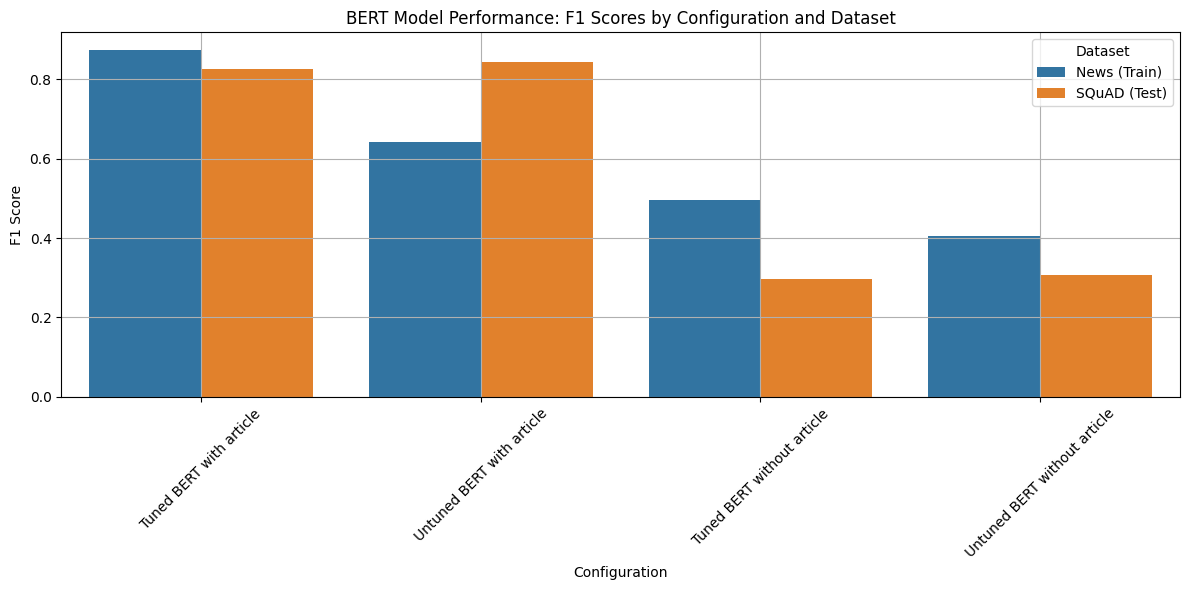

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=score_df, x="Configuration", y="F1-score", hue="DataSet")
plt.title("BERT Model Performance: F1 Scores by Configuration and Dataset")
plt.xlabel("Configuration")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.legend(title="Dataset")
plt.grid()
plt.tight_layout()
plt.show()

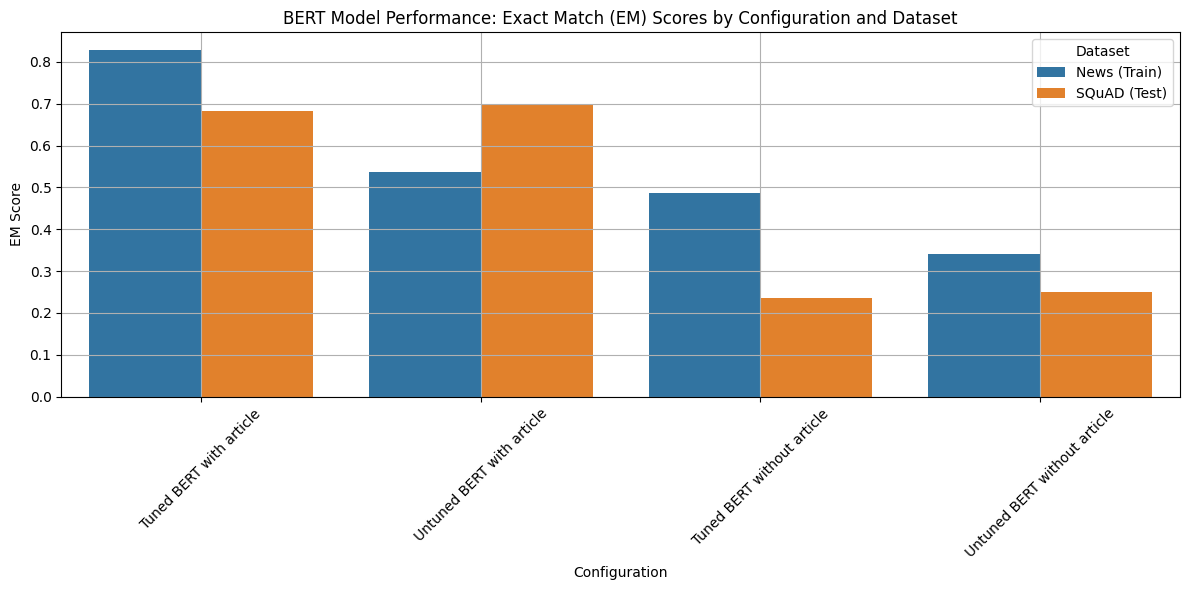

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=score_df, x="Configuration", y="EM", hue="DataSet")
plt.title("BERT Model Performance: Exact Match (EM) Scores by Configuration and Dataset")
plt.xlabel("Configuration")
plt.ylabel("EM Score")
plt.xticks(rotation=45)
plt.legend(title="Dataset")
plt.tight_layout()
plt.grid()
plt.show()

# Interactive Utility for QA system

In [ ]:
article_ID_list = sorted(set(news_df['id']))

def QA_main():
  print("Welcome to the AI question system!")
  print()
  while True:
    question = input("Please enter your question (Enter quit to exit the system):")
    if question.lower() == "quit":
      print("Exit the system successfully!")
      break
    article_id = input("Please enter the reference article ID (if not, enter no): ")
    if article_id.lower() == 'no':
      article = None
    else:
      try:
        article_id = int(article_id)
        if article_id in article_ID_list:
          article = get_article_by_id(article_id)
        else:
          print("No corresponding article found! But the system will still answer your questions.")
      except:
        print("No corresponding article found! But the system will still answer your questions.")
    pred_answer = generate_answer(question, article, tokenizer = tokenizer, model = model)
    normalized_pred_answer = normalize_answer(pred_answer)
    if len(normalized_pred_answer) == 0:
      normalized_pred_answer = 'there is no answer'
    print("Answer: ", normalized_pred_answer)
    print()



In [ ]:
if __name__ == "__main__":
  QA_main()

Welcome to the AI question system!

Please enter your question (Enter quit to exit the system):What type of missile is North Korea preparing to test according to Kim Jong Un's statement?
Please enter the reference article ID (if not, enter no): no
Answer:  missile

Please enter your question (Enter quit to exit the system):What is the highest murder rate in New York City's precincts?
Please enter the reference article ID (if not, enter no): 17284
Answer:  40th precinct

Please enter your question (Enter quit to exit the system):Who is the vice chairman of Samsung
Please enter the reference article ID (if not, enter no): 17574
Answer:  jay lee

Please enter your question (Enter quit to exit the system):Where is girding for four years of potential discord mentioned?
Please enter the reference article ID (if not, enter no): 17574
Answer:  seoul south korea

Please enter your question (Enter quit to exit the system):Who does Donald J. Trump appear to side with, according to the article?
Pl